## 生成模型
原理：扩充数据样本多样性，提高生成质量。
1、自回归模型
2、GAN：生成对抗网络（生成器负责生成图片、判别器负责判别生成器生成图片与原始图片的真实性）
3、Fllow模型
4、VAE：自分编码器
条件概率：P(A,B,C)=P(A|C,B)*P(C,B)=P(A|C,B)*P(C|B)P(C)
马尔科夫链：P(A,B,C)=P(A|C,B)*P(C,B)=P(A|C)*P(C|B)P(C)
KL散度公式
参数重整化（重参数技巧）：高斯分布N(均值μ，方差σ^2)中采样,先从标准分布N(0,1)中采样z，再得到σ^2*z+μ。为解决采样后的μ，σ不可导问题
5、DM：扩散模型

## 5、扩散模型：
去噪扩散概率模型、基于分数的模型、基于随机微分方程的模型

参数重整化（重参数技巧）：高斯分布N(均值μ，方差σ^2)中采样,先从标准分布N(0,1)中采样z，再得到σ^2*z+μ。为解决采样后的μ，σ不可导问题
1、正向扩散：
完全不含参数，根据初始分布，知道任意t时刻分布
q（Xt|Xt-1）= N(Xt;sqrt(1-beta_t)*Xt-1,beta_t*I) 0<beta_t<1,越来越大
q（Xt|X0）= N（Xt;sqrt(alpha_bar_t)*X0,(1-alpha_bar_t)*I）,算出t=？（加t步噪声），N(Xt;0,1),接近标准正态分布
2、反向扩撒（条件概率分布）：
q（Xt-1|Xt,X0）
3、目标数据分布

## 5、Diffusion  Probabilistic Model 算法代码 
Deep Unsupervised Learning using Nonequilibrium Thermodynamics-2015/
Denoising Diffusion Probabilistic Models-2022

算法原理：
1、训练：
从目标分步（训练集）中采样数据，随机生成时刻t，生成正态分布的噪声，带入目标函数进行最小化的优化，
2、采样：
T~1迭代遍历，每一时刻生成z，z*μ得到Xt-1，t次迭代后，得到X0

1、选择一个数据集（DDPM生成MNIST数据集）
手写数据集中：60000张·训练集，10000张·测试集，每张图片是（28X28）的灰度图，特征标签为1

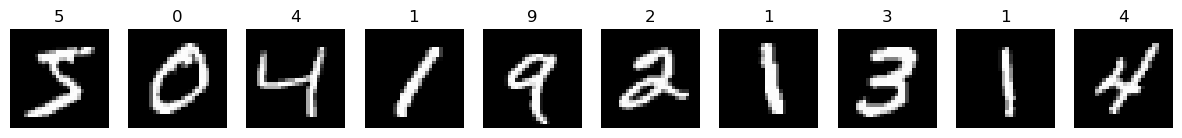

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import datasets, transforms

# 下载并加载 MNIST 数据集
transform = transforms.Compose([
    transforms.ToTensor(),  # 将图像转换为张量
    transforms.Normalize((0.5,), (0.5,))  # 归一化
])

mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
data_loader = torch.utils.data.DataLoader(mnist_dataset, batch_size=64, shuffle=True)

# 可视化一些样本
fig, ax = plt.subplots(1, 10, figsize=(15, 3))
for i in range(10):
    image, label = mnist_dataset[i]
    ax[i].imshow(image.squeeze(), cmap='gray')
    ax[i].set_title(label) #label 的类型是 <class 'int'>，这表明它是一个普通的整数，不需要调用 (label.item()) 方法
    ax[i].axis('off')
plt.show()

# 设备选择
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# 将数据集转换为张量（float类型）并移动到设备
dataset = torch.Tensor(np.array([mnist_dataset[i][0].numpy() for i in range(len(mnist_dataset))])).float().to(device)

In [2]:
#从 mnist数据集中获取第 i 个样本，其中 image 是该样本的图像数据，label 是对应的标签（表示该图像所代表的数字，范围从0到9）
image, label = mnist_dataset[i]
print(type(label))  # 打印标签的类型
print(dataset.shape)

<class 'int'>
torch.Size([60000, 1, 28, 28])


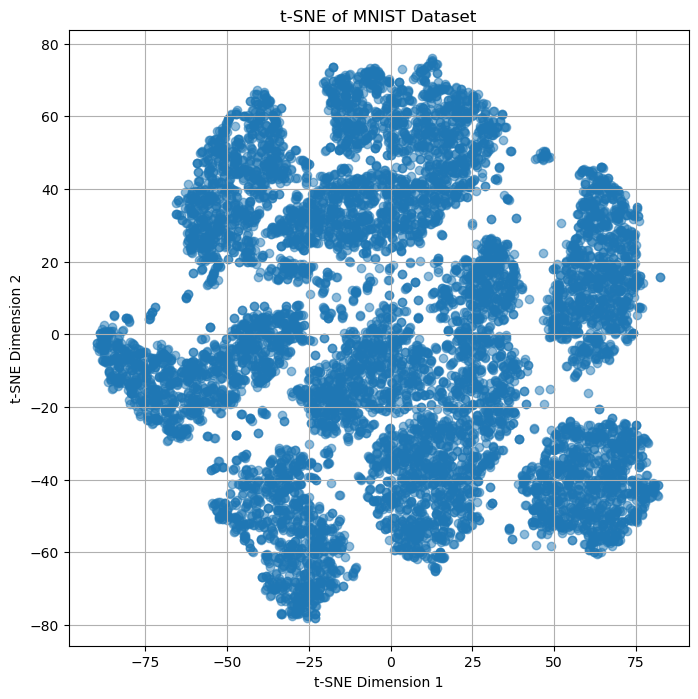

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# 使用你的数据集
data = dataset.reshape(60000, 28 * 28)  # 展平图像，变为 (60000, 784)

# 使用 t-SNE 降维
#聚类情况：在散点图中看到明显的聚类现象，这说明不同数字在高维空间中有不同的特征，从而在降维后仍然保持了这些特征。
tsne = TSNE(n_components=2, random_state=42) #创建一个 t-SNE 实例，设置降维到 2 个维度 (n_components=2)。random_state 是为了确保结果的可重复性。
reduced_data = tsne.fit_transform(data[:10000])  # 只取前10000个样本进行可视化

# 绘制散点图
plt.figure(figsize=(8, 8))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], alpha=0.5)
plt.title("t-SNE of MNIST Dataset")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.grid()
plt.show()

2、设置超参数的值：β，α

αt=1-βt，β越来越大（0.001~0,0.002）
xt=sqrt（αt）xt-1+sqrt（1-αt）*z1
xt-1=sqrt（αt-1）*xt-2+sqrt（1-αt-1）*z2
其中z1，z2是服从高斯分布的噪音,z1~(0,1-αt)
xt=sqrt（αt）*（sqrt（αt-1）*xt-2+sqrt（1-αt-1）*z2）+sqrt（1-αt）*z1 =sqrt(αt*αt-1*···*α0)*x0+sqrt（1-αt*···*α0）*zt
由初始图分布和任意时刻t，得到t步之后的分布。

In [4]:
num_steps = 100 #扩散过程的时间总步数
#betas 控制了每个时间步中噪声的强度
betas = torch.linspace(-6,6,num_steps).to(device) #生成线性序列
betas = torch.sigmoid(betas)*(0.5e-2 - 1e-5)+1e-5  #将线性生成的值通过 Sigmoid 函数进行非线性变换，确保其范围在 (0, 1) 之间。0.0001< β <0.0005
betas

tensor([2.2338e-05, 2.3924e-05, 2.5713e-05, 2.7730e-05, 3.0006e-05, 3.2572e-05,
        3.5466e-05, 3.8729e-05, 4.2407e-05, 4.6552e-05, 5.1224e-05, 5.6487e-05,
        6.2414e-05, 6.9089e-05, 7.6601e-05, 8.5055e-05, 9.4563e-05, 1.0525e-04,
        1.1726e-04, 1.3075e-04, 1.4589e-04, 1.6286e-04, 1.8188e-04, 2.0317e-04,
        2.2698e-04, 2.5358e-04, 2.8325e-04, 3.1630e-04, 3.5306e-04, 3.9387e-04,
        4.3908e-04, 4.8906e-04, 5.4419e-04, 6.0482e-04, 6.7132e-04, 7.4400e-04,
        8.2317e-04, 9.0908e-04, 1.0019e-03, 1.1018e-03, 1.2087e-03, 1.3225e-03,
        1.4431e-03, 1.5700e-03, 1.7028e-03, 1.8409e-03, 1.9836e-03, 2.1298e-03,
        2.2788e-03, 2.4294e-03, 2.5806e-03, 2.7312e-03, 2.8802e-03, 3.0264e-03,
        3.1691e-03, 3.3072e-03, 3.4400e-03, 3.5669e-03, 3.6875e-03, 3.8013e-03,
        3.9082e-03, 4.0081e-03, 4.1009e-03, 4.1868e-03, 4.2660e-03, 4.3387e-03,
        4.4052e-03, 4.4658e-03, 4.5209e-03, 4.5709e-03, 4.6161e-03, 4.6569e-03,
        4.6937e-03, 4.7267e-03, 4.7564e-

In [5]:
#计算alpha中、alpha_prod、alpha_prod_previous、alpha_bar_sqrt等变量的值
#alphas是每一步中保留原始数据信息的比例，beta是添加到数据的噪声比例
alphas = 1-betas
alphas_prod = torch.cumprod(alphas,axis=0)#α累乘
alphas_prod_p = torch.cat([torch.tensor([1]).float().to(device),alphas_prod[:-1]],0) #p表示previous
alphas_bar_sqrt = torch.sqrt(alphas_prod)
one_minus_alphas_bar_log = torch.log(1 - alphas_prod) 
one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_prod) #sqrt（1-αt*···*α0）
posterior_variance = betas * (1-alphas_prod_p) / (1-alphas_prod)
'''
def extract(a,t,x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1,t.cpu())
    return out.reshape(batch_size,*((1,)*(len(x_shape)-1))).to(t.device)
'''
#检查多个张量的形状是否一致,若相同，程序将打印出 betas.shape 的形状
assert alphas.shape==alphas_prod.shape==alphas_prod_p.shape==\
alphas_bar_sqrt.shape==one_minus_alphas_bar_log.shape\
==one_minus_alphas_bar_sqrt.shape
print("all the same shape",betas.shape)

all the same shape torch.Size([100])


In [6]:
one_minus_alphas_bar_sqrt

tensor([0.0047, 0.0068, 0.0085, 0.0100, 0.0114, 0.0127, 0.0141, 0.0154, 0.0167,
        0.0180, 0.0194, 0.0208, 0.0223, 0.0238, 0.0253, 0.0269, 0.0286, 0.0304,
        0.0323, 0.0343, 0.0363, 0.0385, 0.0408, 0.0432, 0.0457, 0.0484, 0.0513,
        0.0543, 0.0574, 0.0607, 0.0642, 0.0679, 0.0718, 0.0759, 0.0801, 0.0846,
        0.0893, 0.0942, 0.0994, 0.1047, 0.1103, 0.1161, 0.1220, 0.1282, 0.1346,
        0.1411, 0.1479, 0.1548, 0.1618, 0.1689, 0.1762, 0.1836, 0.1910, 0.1985,
        0.2060, 0.2135, 0.2211, 0.2286, 0.2362, 0.2436, 0.2511, 0.2584, 0.2657,
        0.2730, 0.2801, 0.2872, 0.2941, 0.3010, 0.3077, 0.3144, 0.3209, 0.3274,
        0.3337, 0.3399, 0.3461, 0.3521, 0.3580, 0.3639, 0.3696, 0.3752, 0.3808,
        0.3862, 0.3916, 0.3969, 0.4021, 0.4072, 0.4122, 0.4172, 0.4220, 0.4268,
        0.4316, 0.4362, 0.4408, 0.4453, 0.4498, 0.4542, 0.4585, 0.4628, 0.4670,
        0.4712])

In [7]:
posterior_variance

tensor([0.0000e+00, 1.1561e-05, 1.6531e-05, 2.0018e-05, 2.3067e-05, 2.6036e-05,
        2.9102e-05, 3.2381e-05, 3.5968e-05, 3.9890e-05, 4.4257e-05, 4.9115e-05,
        5.4558e-05, 6.0632e-05, 6.7454e-05, 7.5096e-05, 8.3673e-05, 9.3295e-05,
        1.0409e-04, 1.1619e-04, 1.2977e-04, 1.4498e-04, 1.6203e-04, 1.8108e-04,
        2.0242e-04, 2.2622e-04, 2.5280e-04, 2.8240e-04, 3.1535e-04, 3.5195e-04,
        3.9252e-04, 4.3743e-04, 4.8700e-04, 5.4160e-04, 6.0156e-04, 6.6722e-04,
        7.3887e-04, 8.1678e-04, 9.0116e-04, 9.9216e-04, 1.0899e-03, 1.1942e-03,
        1.3051e-03, 1.4223e-03, 1.5454e-03, 1.6739e-03, 1.8072e-03, 1.9446e-03,
        2.0851e-03, 2.2280e-03, 2.3722e-03, 2.5167e-03, 2.6604e-03, 2.8024e-03,
        2.9417e-03, 3.0775e-03, 3.2090e-03, 3.3355e-03, 3.4564e-03, 3.5715e-03,
        3.6803e-03, 3.7827e-03, 3.8787e-03, 3.9682e-03, 4.0513e-03, 4.1283e-03,
        4.1993e-03, 4.2647e-03, 4.3246e-03, 4.3795e-03, 4.4297e-03, 4.4754e-03,
        4.5171e-03, 4.5549e-03, 4.5893e-

3、确定扩散过程任意时刻的·采样值

In [8]:
#计算任意时刻的x采样值，基于x_0和重参数化技巧
#重参数化技巧：将随机变量的生成过程分离为一个确定性部分（模型参数）和一个随机部分（标准状态分布中抽取的随机样本），使得梯度能够通过随机部分传递。
def q_x(x_0,t):
    """可以基于x[0]得到任意时刻t的x[t]"""
    
    noise = torch.randn_like(x_0).to(device) #noise是高斯分布中生成的随机噪声
#从张量中获取第 t 个时间步的值，分别代表在时间步 t 时，从 x_0 到 x[t] 的转换中的均值和标准差。
    alphas_t = alphas_bar_sqrt[t] #均值
    #控制原始数据 x_0 在 x[t] 中的比重
    alphas_1_m_t = one_minus_alphas_bar_sqrt[t] #标准差
    #控制添加到 x_0 的噪声的比重
    return (alphas_t * x_0 + alphas_1_m_t * noise) #返回添加噪声后的x[t]图像


4、演示原始数据分布加噪100步后的效果

<>:19: SyntaxWarning: invalid escape sequence '\m'
<>:19: SyntaxWarning: invalid escape sequence '\m'
C:\Users\honor\AppData\Local\Temp\ipykernel_11992\1557748801.py:19: SyntaxWarning: invalid escape sequence '\m'
  axs[j,k].set_title('$q(\mathbf{x}_{'+str(i*num_steps//num_shows)+'})$')


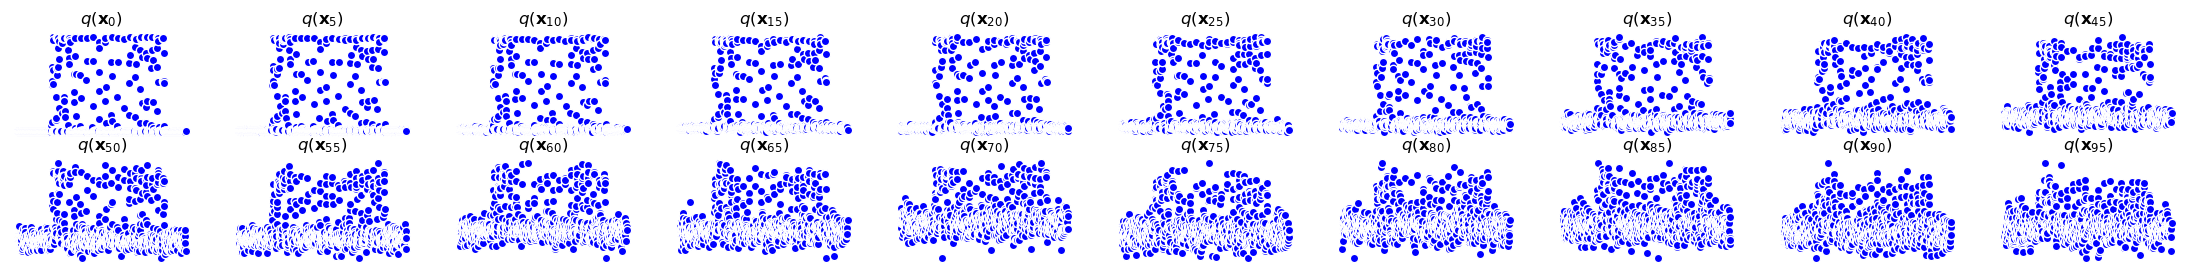

In [9]:
#正向扩散过程散点图演示
num_shows = 20
fig,axs = plt.subplots(2,10,figsize=(28,3))
plt.rc('text',color='black')

#共有60000个点，每个点包含784个坐标
#生成100步以内每隔5步加噪声后的图像
for i in range(num_shows): #t=i*t
    j = i//10
    k = i%10
    q_i = q_x(dataset, torch.tensor([i*num_steps//num_shows]).to(device))#生成t时刻的采样数据
    q_i = q_i.to('cpu')
#q_i 是形状为 [60000, 1, 28, 28] 的张量，首先展平并提取第一张图像的数据
    index = 0  # 选择要绘制的图像索引
    image_data = q_i[index, 0].view(-1)  # 将图像展平为一维数组
    
    axs[j,k].scatter(range(image_data.size(0)), image_data, color='blue', edgecolor='white')
    axs[j,k].set_axis_off()
    axs[j,k].set_title('$q(\mathbf{x}_{'+str(i*num_steps//num_shows)+'})$')

In [10]:
print(q_i.shape)

torch.Size([60000, 1, 28, 28])



4、反向扩散过程高斯分布模型：去噪过程
贝叶斯公式：q（xt−1​∣xt​，x0​）μ~​t​（xt​，x0​）βt​~​=N（xt−1​;μ~​t​（xt​，x0​），βt​~​I）

In [11]:
import torch
import torch.nn as nn

class MLPDiffusion(nn.Module):
    def __init__(self,n_steps,num_units=128):
        super(MLPDiffusion,self).__init__() #
        
        self.linears = nn.ModuleList(
            [
                nn.Linear(1,num_units), #输入层，1个特征值
                nn.ReLU(),
                nn.Linear(num_units,num_units), #隐藏层 1：128 个神经元，使用 ReLU 激活
                nn.ReLU(),
                nn.Linear(num_units,num_units),#隐藏层 2：128 个神经元，使用 ReLU 激活
                nn.ReLU(),
                nn.Linear(num_units,1),#输出层：输出 1 个值
            ]
        )
        self.step_embeddings = nn.ModuleList( #嵌入层
            [
                nn.Embedding(n_steps,num_units), #n_step=100
                nn.Embedding(n_steps,num_units),
                nn.Embedding(n_steps,num_units),
            ]
        )
    def forward(self,x,t): #前向扩散，接收原始图像x = x_0和t
        x = x.view(-1, 1)  # 调整x的形状为(128, 1)
        for idx,embedding_layer in enumerate(self.step_embeddings):
            t_embedding = embedding_layer(t) #将时间步t 通过嵌入层转换为嵌入表示
            t_embedding = t_embedding.sum(dim=1, keepdim=True)
            print(t_embedding.shape)
            x = self.linears[2*idx](x) #对输入x进行线性变换
            print(f"After linear {2*idx}: x shape {x.shape}")
            x += t_embedding
            x = self.linears[2*idx+1](x)
            
        x = self.linears[-1](x)
        return x

6、损失函数

In [12]:
#扩散模型，原始图像，总的时间步数
def diffusion_loss_fn(model,x_0,alphas_bar_sqrt,one_minus_alphas_bar_sqrt,n_steps): 
    """对任意时刻t进行采样计算loss"""
    batch_size = x_0.shape[0] #x_0为（128x2）
    
    #对一个批大小batch_size样本生成随机的时刻t,将这些时间步与n_steps-1-t组合，以获得更多样本
    t = torch.randint(0,n_steps,size=(batch_size//2,)) #(64)
    t = torch.cat([t,n_steps-1-t],dim=0) #[128]
    t = t.unsqueeze(1) #增加一个维度(128,1)
    # 增加一个维度，变为 (128, 2)
    t = torch.cat((t, t), dim=1)  # 将 t 和自身沿第二维连接，现在 t 的形状是 (128, 2)
    print(t.shape)  # 输出: torch.Size([128, 2])
    
    a = alphas_bar_sqrt[t[:, 0]].squeeze()    #x0的系数
    aml = one_minus_alphas_bar_sqrt[t[:, 0]].squeeze() #e的系数
    e = torch.randn_like(x_0).to(device) #生成随机噪音e
    #将原始数据X0按照系数α和随机噪声e组合，得到生成模型的输入x
    x = x_0 * a.unsqueeze(1) + e * aml.unsqueeze(1)
    print(f"x shape: {x.shape}, t shape: {t.shape}")
    print(f"x_0 shape: {x_0.shape}")
    print(f"alphas_bar_sqrt shape: {alphas_bar_sqrt.shape}")
    print(f"one_minus_alphas_bar_sqrt shape: {one_minus_alphas_bar_sqrt.shape}")
    print(f"e shape: {e.shape}")

    output = model(x,t) #模型预测的噪声,(128,2)
     #计算真实噪声e与预测的噪声均方误差，作为损失返回
    loss = (e - output).square().mean
    
    return loss

7、逆扩散采样过程

In [13]:
def p_sample_loop(model,shape,n_steps,betas,one_minus_alphas_bar_sqrt):
    """从x[T]恢复x[T-1]、x[T-2]|...x[0]"""
    cur_x = torch.randn(shape).to(device) # 初始化随机噪声
    x_seq = [cur_x]  # 保存每个时间步的样本序列
    for i in reversed(range(n_steps)):
        cur_x = p_sample(model,cur_x,i,betas,one_minus_alphas_bar_sqrt)
        x_seq.append(cur_x) # 将当前样本添加到序列中
    return x_seq

def p_sample(model,x,t,betas,one_minus_alphas_bar_sqrt):
    """从x[T]采样t时刻的重构值"""
    t = torch.tensor(t).to(device)
    coeff = betas[t] / one_minus_alphas_bar_sqrt[t]
    eps_theta = model(x,t) # 将当前样本 x 和时间步 t 输入模型，得到噪声预测
    mean = (1/(1-betas[t]).sqrt())*(x-(coeff*eps_theta)) # 计算均值
    z = torch.randn_like(x).to(device)  # 生成与 x 形状相同的随机噪声 z
    sigma_t = betas[t].sqrt() # 计算标准差
    sample = mean + sigma_t * z # 生成最终样本，结合均值和噪声
    return (sample)

8、开始训练模型，打印损失loss

In [14]:
seed = 1234

print('Training model...')
batch_size = 128
dataloader = torch.utils.data.DataLoader(dataset,batch_size=batch_size,shuffle=True)
num_epoch = 4000 # 训练的轮数
plt.rc('text',color='blue')

model = MLPDiffusion(num_steps)#输出维度是2，输入是x和step
model = model.cpu()
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3) #使用Adam优化器，学习率为0.001
device = 'cpu'

# 开始训练循环
for t in range(num_epoch):
    for idx,batch_x in enumerate(dataloader):
        # 假设 batch_x 形状为 (128, 1, 28, 28)
        batch_x = batch_x.view(batch_size, -1) # 将其调整为 (128, 784)
        feature1 = batch_x.mean(dim=1, keepdim=True)  # (128, 1)
        feature2 = torch.randint(0, num_steps, (batch_size,)).unsqueeze(1).float()  # (128,1)
        combined_input = torch.cat((feature1, feature2), dim=1)  # 变成 (128, 2)
        #计算损失
        loss = diffusion_loss_fn(model,
                                 combined_input,
                                 alphas_bar_sqrt,
                                 one_minus_alphas_bar_sqrt,
                                 num_steps)
        #优化步骤
        optimizer.zero_grad() # 清空梯度
        loss.backward() # 反向传播
        torch.nn.utils.clip_grad_norm_(model.parameters(),1.) # 梯度裁剪，防止爆炸
        optimizer.step() # 更新参数

    
    if(t%100==0):
        print(loss) #每间隔10步，打印采样结果
        shape = (batch_size, 1)  # 确保形状为 (batch_size, 2)
        x_seq = p_sample_loop(model,
                              dataset.shape,
                              num_steps,
                              betas,
                              one_minus_alphas_bar_sqrt)
        
        x_seq = [item.to('cpu') for item in x_seq]
        fig,axs = plt.subplots(1,10,figsize=(28,3))
        for i in range(1,11):
            cur_x = x_seq[i*10].detach()
            axs[i-1].scatter(cur_x[:,0],cur_x[:,1],color='red',edgecolor='white');
            axs[i-1].set_axis_off();
            axs[i-1].set_title('$q(\mathbf{x}_{'+str(i*10)+'})$')

Training model...
torch.Size([128, 2])
x shape: torch.Size([128, 2]), t shape: torch.Size([128, 2])
x_0 shape: torch.Size([128, 2])
alphas_bar_sqrt shape: torch.Size([100])
one_minus_alphas_bar_sqrt shape: torch.Size([100])
e shape: torch.Size([128, 2])
torch.Size([128, 1, 128])
After linear 0: x shape torch.Size([256, 128])


<>:50: SyntaxWarning: invalid escape sequence '\m'
<>:50: SyntaxWarning: invalid escape sequence '\m'
C:\Users\honor\AppData\Local\Temp\ipykernel_11992\2788450710.py:50: SyntaxWarning: invalid escape sequence '\m'
  axs[i-1].set_title('$q(\mathbf{x}_{'+str(i*10)+'})$')
C:\Users\honor\AppData\Local\Temp\ipykernel_11992\2788450710.py:50: SyntaxWarning: invalid escape sequence '\m'
  axs[i-1].set_title('$q(\mathbf{x}_{'+str(i*10)+'})$')


RuntimeError: output with shape [256, 128] doesn't match the broadcast shape [128, 256, 128]

9、动画演示前向扩散和反向扩散过程

In [ ]:
import io
from PIL import Image
imgs=[]
for i in range(100):
    plt.clf()
    q_i=q_x(dataset,torch.tensor([i]))
    plt.scatter(q_i[:,0],q_i[:,1],color='red',edgecolor='white',s=5);
    plt.axis('off');
    img_buf=io.BytesIO()
    plt.savefig(img_buf,format='png')
    img=Image.open(img_buf)
    imgs.append(img)

In [ ]:
#Generating the reverse diffusion sequence 
reverse = []
for i in range(100):
    plt.clf()
    cur_xx_seq[i].detach()#到训练末尾阶段生成的x_seq
    plt.scatter(cur_x[:,0],cur_x[:,1],color='red',edgecolor='white',s=5);
    plt.axis('off')
    img_bufio.BytesIO()
    plt.savefig(img_buf,format='png')
    imgImage.open(img_buf)
    reverse.append(img)
imgs = imgs+reverse
imgs[0].save("diffusion.gif",
             format='GIF',
             append_images=imgs,
             save_all=True,
             duration=100,
             loop=0)